In [1]:
sc.install_pypi_package( "pandas==1.0.4" )
sc.install_pypi_package( "matplotlib==3.2.1" )
sc.install_pypi_package("imblearn==0.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1591391100289_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("scikit-learn==0.23.1")
sc.install_pypi_package("sklearn==0.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: /var/lib/livy/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn

In [3]:
import sys
import pandas as pd
from pyspark.sql import SparkSession
# create sparksession
spark = SparkSession \
    .builder \
    .appName("insight") \
    .getOrCreate()
acquis = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Acquisition_2010Q1.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

perf = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Performance_2010Q1.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
col_names_aquisition = ['loanID', 'originationChannel', 'sellerName', 'origIntRate', 'origUPB', 
                       'origLoanTerm', 'originationDate', 'firstPaymentDate', 'LTV', 'CLTV', 
                        'numOfBorrowers', 'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
                       'firstTimeBuyerIndicator', 'loanPurpose', 'propertyType', 'numOfUnits',
                       'occupancyType', 'propertyState', 'zipCodeShort', 'primaryMortgInsurPercent', 
                       'productType', 'coborrowerCreditScoreAtOrig', 'mortgageInsurType', 
                       'relocationMortgIndicator']
col_names_performance =['loanID', 'monthlyReportingPeriod', 'servicerName', 'currentIntRate',
                       'currentActualUPB', 'loanAge', 'remMonthsToLegalMaturity', 'adjMonthToMaturity',
                       'maturityDate', 'MSA', 'currentLoanDelinqStatus', 'modifFlag', 'zeroBalanceCode',
                       'zeroBalanceEffectiveDate', 'lastPaidInstallDate', 'foreclosureDate',
                       'dispositionDate', 'foreclosureCost', 'propPreservAndReparCosts', 'assetRecoveryCosts',
                       'miscelHoldingExpensesAndCredits', 'associatedTaxesForHoldingProperty', 'netSaleProceeds',
                       'creditEnhacementProceeds', 'repurchaseMakeWholeProceeds','otherForeclosureProceeds',
                       'nonInterestBearingUPB', 'principalForegivenessAmount', 'repurchaseMakeWholeProceedsFlag',
                       'foreclosurePrincipWriteOffAmont', 'servicingActivityIndicator']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
i = 0
acquis_rn = acquis
for colname in col_names_aquisition:
    acquis_rn = acquis_rn.withColumnRenamed("_c"+str(i),col_names_aquisition[i])
    i = i + 1
    
i = 0
perf_rn = perf
for colname in col_names_performance:
    perf_rn = perf_rn.withColumnRenamed("_c"+str(i),col_names_performance[i])
    i = i + 1
#acquis_rn.select(acquis_rn.columns[:7]).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import IntegerType
perf_rn = perf_rn.withColumn("monthlyReportingPeriod",to_date(perf_rn.monthlyReportingPeriod,'MM/dd/yyyy'))
perf_rn = perf_rn.withColumn("currentLoanDelinqStatus", perf_rn["currentLoanDelinqStatus"].cast(IntegerType()))
acquis_rn = acquis_rn.withColumn("originationDate",to_date(acquis_rn.originationDate,'MM/yyyy'))
acquis_rn = acquis_rn.withColumn("firstPaymentDate",to_date(acquis_rn.firstPaymentDate,'MM/yyyy'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
perf_rn.createOrReplaceTempView('perf')
_2010Q1_perf = spark.sql(
'''
SELECT 
perf.loanID, perf.monthlyReportingPeriod, perf.loanAge, perf.currentLoanDelinqStatus FROM perf 

'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
pivot_perf =_2010Q1_perf.groupBy("loanID").pivot("monthlyReportingPeriod").max("currentLoanDelinqStatus")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
final_perf = pivot_perf.select(pivot_perf.columns[0:28])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
acquis_rn.createOrReplaceTempView('acquis')
sql_acquis = spark.sql(
'''
SELECT acquis.loanID, acquis.origIntRate, acquis.origUPB, acquis.originationDate, 
acquis.firstPaymentDate, acquis.LTV, acquis.CLTV, acquis.numOfBorrowers, acquis.origDebtToIncomeRatio, 
acquis.borrowerCredScoreAtOrigination, acquis.zipCodeShort, acquis.primaryMortgInsurPercent
FROM acquis WHERE (originationDate BETWEEN '2010-01-01'AND '2010-12-01')

'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
_2010Q1 = sql_acquis.join(final_perf,on=['loanID'],how='inner')
#print((_2010Q1.count(), len(_2010Q1.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
from pyspark.sql.functions import greatest
clist = _2010Q1.columns[-14:]
_2010Q1 = _2010Q1.withColumn("default_status",greatest(*clist))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
_2010Q1.groupBy("default_status").count().sort("default_status").show(7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------+
|default_status| count|
+--------------+------+
|          null| 15412|
|             0|147998|
|             1|  3494|
|             2|   359|
|             3|   123|
|             4|    98|
|             5|    67|
+--------------+------+
only showing top 7 rows

In [15]:
_2010Q1 = _2010Q1.filter(_2010Q1.default_status. isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
columns_to_drop = ['loanID', 'primaryMortgInsurPercent', '2010-01-01','2010-02-01', 'originationDate', 'firstPaymentDate']
_2010Q1 = _2010Q1.drop(*columns_to_drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
tclean = _2010Q1.filter(_2010Q1.default_status. isNotNull())
tclean.na.drop()
print(tclean.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

152452

In [18]:
from pyspark.sql.functions import udf,col
default_label = udf(lambda x : 0 if x <= 4 else 1, IntegerType())
_2010Q1 = _2010Q1.withColumn("default_status",default_label(col("default_status")))
_2010Q1.select(_2010Q1.columns[30:]).show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+----------+--------------+
|2012-01-01|2012-02-01|2012-03-01|default_status|
+----------+----------+----------+--------------+
|         0|         0|         0|             0|
|         0|         0|         0|             0|
+----------+----------+----------+--------------+
only showing top 2 rows

In [19]:
to_drop=['2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01', 
'2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', '2011-01-01', '2011-02-01', 
'2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01', 
'2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01']
_2010Q1_limited = _2010Q1.drop(*to_drop)
print(_2010Q1.count(), len(_2010Q1.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

152452 34

In [20]:
_cols = _2010Q1_limited.columns
_2010Q1_cleaned = _2010Q1_limited
for _c in _cols:
    _2010Q1_cleaned = _2010Q1_cleaned.filter(_2010Q1_cleaned[_c]. isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
_2010Q1_cleanedPandas =_2010Q1_cleaned.toPandas()
y = _2010Q1_cleanedPandas['default_status'].values
X = _2010Q1_cleanedPandas.drop(['default_status'], axis=1).values
X_resampled, y_resampled = sm.fit_sample(X, y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
X = pd.DataFrame(data=X_resampled, index=None, columns=['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers',
       'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
       'zipCodeShort'])
y=pd.Series(y_resampled)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

rng = np.random.RandomState(seed=42)


categorical_columns = []
numerical_columns = ['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers',
       'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
       'zipCodeShort']


X1 = X[categorical_columns + numerical_columns]
y1=y

#spliting of data into test and train
X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y1, stratify=y, random_state=42)

#pipeline for one-hot encoding of categorical features
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#imputer in case value is missing from numerical feature
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
#processing data
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
#setting up the model
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
rf.fit(X1_train, y_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['origIntRate', 'origUPB',
                                                   'LTV', 'CLTV',
                                                   'numOfBorrowers',
                                                   'origDebtToIncomeRatio',
                                                   'borrowerCredScoreAtOrigination',
                                                   'zipCodeShort'])])),
   

In [37]:
print("RF train accuracy: %0.3f" % rf.score(X1_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X1_test, y_test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RF train accuracy: 1.000
RF test accuracy: 0.998

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

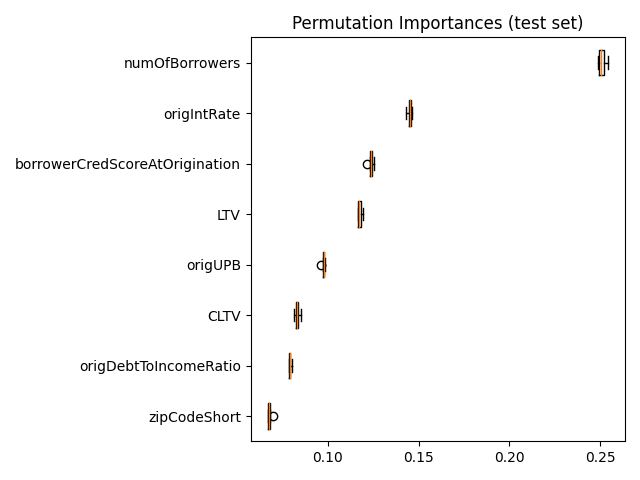

In [55]:
import matplotlib
import matplotlib.pyplot as plt

result = permutation_importance(rf, X1_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X1_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
%matplot plt

In [23]:
_2010Q1_cleanedPandas.drop(['default_status'], axis=1).columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers',
       'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
       'zipCodeShort'],
      dtype='object')

In [24]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
X_resampled, y_resampled = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=0)

model = RandomForestClassifier(n_estimators=300)
model = model.fit(X_train, y_train)
predict = model.predict(X_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
print("RF train accuracy: %0.3f" % model.score(X_train, y_train))
print("RF test accuracy: %0.3f" % model.score(X_test, y_test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RF train accuracy: 1.000
RF test accuracy: 0.998

In [ ]:

X_test = pd.DataFrame(data=X_test, index=None, columns=['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers',
       'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
       'zipCodeShort'])
y_test=pd.Series(y_test)